In [1]:
import numpy as np
import scipy
from scipy import integrate
from numpy.random import default_rng
from multiprocessing import Pool
import nfwFunctions as NFW
import inverseTransform
import time

from scipy import special
from scipy.interpolate import interp1d
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

In [3]:
class nfwHalo(): # Our NFW halo object
    def __init__(self, nTracers, rScale, rho0, delta, rhoCritical = 1.26*10**-7, useParallel = True, numThreads = 4):
        """
        NFW Halo. This init just stores some of the arguments passed in and computes some important/handy quantities.
        
        Important properties of a nfwHalo object:
        
        radii - radii of generated tracers
        normRadii - radii of generated tracers normalized to the cutoff radius rDelta
        speeds - speeds of the generated tracers
        coordAngles - the spherical coordinate angles (theta, phi) for each tracer in position space
        velocityAngles - the spherical coordinate angles (theta, phi) for each tracer in velocity space
        
        sphericalPhaseSpacePoints - contains the 6D phase space of all tracers in spherical coordinates
        cartesianPhaseSpacePoints - contains the 6D phase space of all tracers in cartesian coordinates
        """
        self.nTracers = nTracers # number of tracer stars. Halo attribute 0
        self.rScale = rScale # scale radius for NFW profile, this is sometimes called a. Halo attribute 1
        self.rho0 = rho0 # scale density for NFW profile. Halo attribute 2
        self.delta = delta # cutoff scale. Halo attribute 3
        self.rhoCritical = rhoCritical # Halo attribute 4
        rhoNorm = self.rho0/(self.delta*self.rhoCritical)
        cShortcut = ((3.*np.sqrt(81.*rhoNorm**2. + 12.*rhoNorm) + 27.*rhoNorm + 2.)/2.)**(1./3.)
        self.c = ( cShortcut + 1./cShortcut - 2 )/3. # Halo attribute 5
        self.rDelta = self.c*self.rScale # Halo attribute 6
        self.G = 4.3009*10**-3 # Newton's constant, (pc/solar mass) * (km/second)^2. Halo attribute 7
        self.mHalo = (4*np.pi*self.rho0*self.rScale**3)*NFW.gFcn(self.c) # Should be in units of solar masses. Halo attribute 8
        self.virialSpeed = np.sqrt(self.G*self.mHalo/self.rDelta) # Halo attribute 9
        
        self.haloAttributes = np.array((self.nTracers,self.rScale,self.rho0,self.delta,self.rhoCritical,self.c,self.rDelta,self.G,self.mHalo,self.virialSpeed))
        self.nt = numThreads
        self.useParallel = useParallel
        
    def genTracerCoords(self):
        """
        Our halo needs tracer stars, and those tracer stars need coordinates! (otherwise they wouldn't be anywhere...) You should probably avoid
        calling this function, since the calculation of velocities will actually need the list of radii this function generates. If you were to
        generate these radii, then generate velocities, but then generate radii again the velocities wouldn't update. So this should only be called
        in the genTracers() method.
        
        This defines two class properties: radii and sphericalCoordinateAngles. radii is self-explanatory, sphericalCoordinateAngles is a 2-row array where the first
        row is the list of polar angles (theta) called like sphericalCoordinateAngles[0,:] and the second row is the list of azimuthal angles (phi) called like
        sphericalCoordinateAngles[1,:].
        """
        self.radiiNorm = np.zeros(self.nTracers)
        if self.useParallel==True:
            if __name__ == '__main__':
                with Pool(processes=self.nt) as pool:
                    result_list = []
                    for k in range(self.nt):
                        result_list.append(
                            pool.apply_async(
                                inverseTransform.inverseTransformSamplingRadius,
                                (len(np.arange(k,nTracers,self.nt)),
                                 self.haloAttributes,
                                 (0,1),
                                 self.rScale/self.rDelta,
                                 .5*(self.rScale/self.rDelta+1)
                                 ,
                                )
                            )
                        )
                    for k in range(self.nt):
                        self.radiiNorm[np.arange(k,nTracers,self.nt)]=result_list[k].get()
                    pool.close()
                    pool.join()
        else:
            self.radiiNorm = np.array(inverseTransform.inverseTransformSamplingRadius(self.nTracers, self.haloAttributes, bracket = (0, 1), x0=self.rScale/self.rDelta, x1=.5*(self.rScale/self.rDelta+1)))
        self.radii = self.radiiNorm * self.rDelta
        self.coordAngles = np.array([np.arccos(2*default_rng().uniform(0,1,self.nTracers)-1),default_rng().uniform(0,1,self.nTracers)*2*np.pi]) # first row is theta, second row is phi
    
    def genPhaseSpaceTable(self,nTabulatedRadii=100,nTabulatedSpeeds=100):
        self.psTable = np.zeros((nTabulatedRadii,nTabulatedSpeeds))
        self.tabNormRadii = np.linspace(0,1,nTabulatedRadii)
        self.tabSpeeds = np.linspace(0,NFW.maxSpeed(.001,self.haloAttributes),nTabulatedSpeeds)
        self.speedCubicSplines = []
        for i in range(nTabulatedRadii):
            for j in range(nTabulatedSpeeds):
                self.psTable[i,j] = NFW.phaseSpaceDistribution(self.tabNormRadii[i],self.tabSpeeds[j],self.haloAttributes)
            self.speedCubicSplines.append(interp1d(self.tabSpeeds,self.psTable[i,:],kind='cubic',fill_value='extrapolate'))
            if i % int(nTabulatedRadii/10) == 0:
                print(100*i/nTabulatedRadii)
        
    def genTracerVelocities(self,nTabulatedRadii=100,nTabulatedSpeeds=100):
        """
        This should build a list of tracer speeds + directions using the speedCDF we define earlier via inverse transform sampling.
        """
        self.genPhaseSpaceTable(nTabulatedRadii,nTabulatedSpeeds)
        self.speeds = np.zeros(self.nTracers)
        if self.useParallel==True:
            if __name__ == '__main__':
                with Pool(processes=self.nt) as pool:
                    result_list = []
                    for k in range(self.nt):
                        result_list.append(
                            pool.apply_async(
                                inverseTransform.inverseTransformSamplingVelocity,
                                (
                                    len(np.arange(k,nTracers,self.nt)),
                                    self.haloAttributes,
                                    self.radiiNorm[np.arange(k, nTracers, self.nt)],
                                    self.psTable,
                                    self.tabNormRadii,
                                    self.speedCubicSplines,
                                )
                            )
                        )
                    for k in range(self.nt):
                        self.speeds[np.arange(k,nTracers,self.nt)]=result_list[k].get()
                    pool.close()
                    pool.join()
        else:
            self.speeds = np.array(inverseTransform.inverseTransformSamplingVelocity(nTracers, self.haloAttributes, self.radiiNorm, self.psTable, self.tabNormRadii, self.speedCubicSplines,))
        self.velocityAngles = np.array([np.arccos(2*default_rng().uniform(0,1,self.nTracers)-1),default_rng().uniform(0,1,self.nTracers)*2*np.pi]) # first row is theta, second row is phi
        
    def genTracers(self,nTabulatedRadii=100,nTabulatedSpeeds=100):
        """
        Should automatically generate a full set of tracer particles with coordinates and velocities that obey an NFW profile.
        """
        print("Generating " + str(self.nTracers) + " coordinates, please wait...")
        time0=time.time()
        self.genTracerCoords()
        time1=time.time()
        print("Coordinates generated in " + str(round(time1-time0,2)) + " seconds.")
        print("Generating " + str(self.nTracers) + " velocities, please wait...")
        time0 = time.time()
        self.genTracerVelocities(nTabulatedRadii,nTabulatedSpeeds)
        time1 = time.time()
        print("Velocities generated in " + str(round(time1-time0,2)) + " seconds.")
        self.sphericalPhaseSpacePoints = [self.radii,
                                          self.coordAngles[0,:],
                                          self.coordAngles[1,:],
                                          self.speeds,
                                          self.velocityAngles[0,:],
                                          self.velocityAngles[1,:]
                                         ]
        self.cartesianPhaseSpacePoints = [self.radii*np.cos(self.coordAngles[1,:])*np.sin(self.coordAngles[0,:]),
                                          self.radii*np.sin(self.coordAngles[1,:])*np.sin(self.coordAngles[0,:]),
                                          self.radii*np.cos(self.coordAngles[0,:]),
                                          self.speeds*np.cos(self.velocityAngles[1,:])*np.sin(self.velocityAngles[0,:]),
                                          self.speeds*np.sin(self.velocityAngles[1,:])*np.sin(self.velocityAngles[0,:]),
                                          self.speeds*np.cos(self.velocityAngles[0,:])
                                         ]
        print("All " + str(self.nTracers) + " tracers generated.")
        
    def saveHalo(self):
        """
        Saves a copy of the tracer information. Right now loading these in seems to be bugged.
        """
        t = time.localtime()
        timestamp = time.strftime('%b_%d_%Y_%H%M', t)
        metaLabels = np.array(('nTracers','rScale','mwHaloDensity','delta','criticalDensity'))
        haloAttrib = np.array((self.nTracers,self.rScale,self.rho0,self.delta,self.rhoCritical))
        phaseSpaceLabels = np.array(('x_pc','y_pc','z_pc','vx_km_s','vy_km_s','vz_km_s'))
        np.savez('generatedHalos//nfwGeneratedTracers_'+timestamp,metaLabels,haloAttrib,phaseSpaceLabels,self.cartesianPhaseSpacePoints)

In [4]:
# Let's make a halo!

# Halo parameters
nTracers = 10**6
rScale = 15*10**3 # Lin, Li "The Dark Matter Profiles in the Milky Way" https://arxiv.org/abs/1906.08419
mwHaloDensity = 3.8 * 10 ** -2 # Solar masses per cubic parsec, Milky way DM halo density (SOFUE 2011)
delta = 200
criticalDensity = 1.26 * 10 ** -7 # Solar masses per cubic parsec

# Create an instance of the nfwHalo class
mwHalo = nfwHalo(nTracers,rScale,mwHaloDensity,delta,criticalDensity,useParallel=True,numThreads=4)

# Print out some information about the halo
print('rScale is : '+str(mwHalo.rScale),', rDelta is: ' + str(mwHalo.rDelta))
print('the concentration must then be: ' + str(mwHalo.c))

# Generates the 6D coordinates of nTracer # of tracers using the provided characteristics of the halo.
mwHalo.genTracers(200,200)



rScale is : 15000 , rDelta is: 162157.59323373693
the concentration must then be: 10.810506215582462
Generating 1000000 coordinates, please wait...
Coordinates generated in 37.89 seconds.
Generating 1000000 velocities, please wait...
0.0


C:\Users\ericr\Desktop\Rutgers\nfwHalo\nfwFunctions.py:33: RuntimeWarning: invalid value encountered in double_scalars
  Phi = -energyNorm*np.log(1+c*radiusNorm)/(c*radiusNorm)


10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
Velocities generated in 3862.3 seconds.
All 1000000 tracers generated.


In [7]:
#plt.imshow(np.transpose(mwHalo.psTable),origin='lower',aspect='auto',cmap='RdBu_r')
#mwHalo.tabSpeeds
np.shape(mwHalo.psTable)

(1000, 1000)

In [5]:
# Saving the generated halo so we can load it up in another file
saveHalo = True
if saveHalo == True:
    mwHalo.saveHalo()
    

<h1>Tracer Coordinates</h1>

Text(0.5, 0, 'Z (pc)')

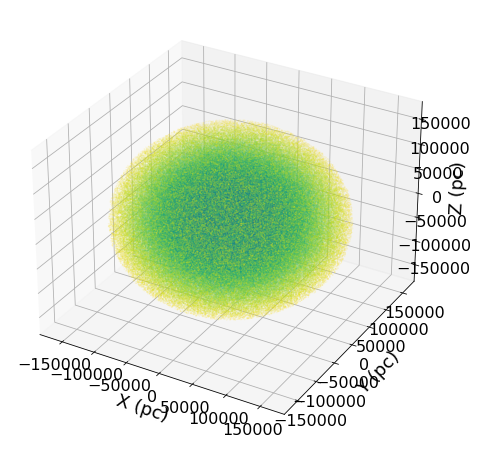

In [7]:
# 3D scatterplot of tracer star locations
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mwHalo.cartesianPhaseSpacePoints[0],mwHalo.cartesianPhaseSpacePoints[1],mwHalo.cartesianPhaseSpacePoints[2],c=mwHalo.radii,s=.01)
ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')

# Colored by radius, from dark blue to yellow

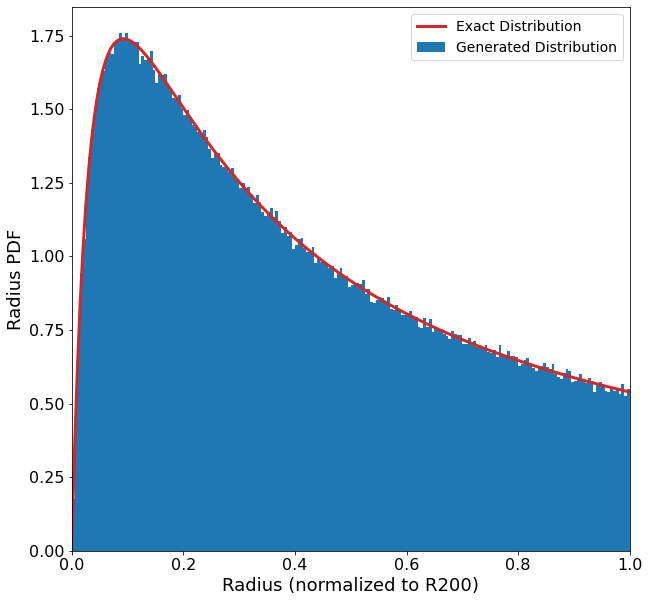

In [8]:
# Comparing the generated and theoretical probability distribution function for the halo radii.
fig, ax1 = plt.subplots(figsize=(10,10))

steps = 200

color = 'tab:blue'
ax1.set_xlabel('Radius (normalized to R200)')
ax1.set_ylabel('Radius PDF')
x_vals, bins, p=ax1.hist(mwHalo.radiiNorm,steps,color=color,density=True,label="Generated Distribution",align='mid')

color = 'tab:red'
r = np.linspace(0,1,steps)
pdf = []
for i in range(steps):
    pdf.append(NFW.radialPDF(r[i],mwHalo.haloAttributes))
ax1.plot(r,pdf, color=color,linewidth=3,label="Exact Distribution")
ax1.legend()
ax1.set_xlim(0,1)

plt.show()

<h2> Tracer Velocities</h2>

Text(0.5, 0, 'Vz (km/s)')

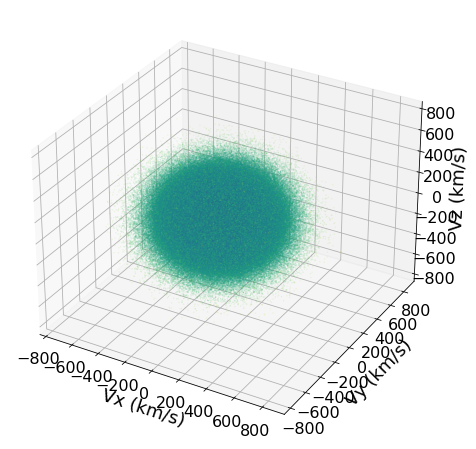

In [9]:
# 3D scatterplot of tracer star velocities
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mwHalo.cartesianPhaseSpacePoints[3],mwHalo.cartesianPhaseSpacePoints[4],mwHalo.cartesianPhaseSpacePoints[5],c=mwHalo.speeds,s=.01)
ax.set_xlabel('Vx (km/s)')
ax.set_ylabel('Vy (km/s)')
ax.set_zlabel('Vz (km/s)')

# Colored by speed, from dark blue to yellow

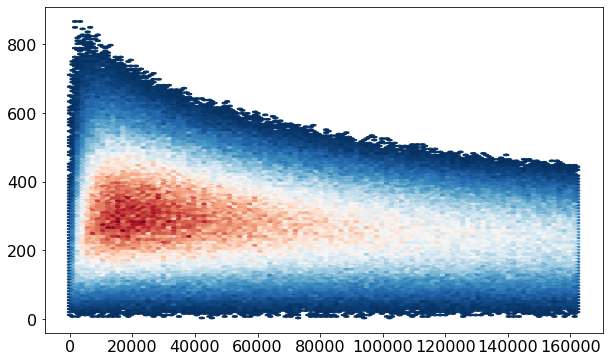

In [11]:
plt.hexbin(
    mwHalo.radii, 
    mwHalo.speeds,
    mincnt=1,gridsize=(100,100),cmap='RdBu_r'
)

<h1>Spherical Velocities</h1>

<ipython-input-12-9be0bfd4a10b>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  phiUnitVec = np.array((-mwHalo.cartesianPhaseSpacePoints[1]/np.sqrt(mwHalo.cartesianPhaseSpacePoints[0]**2+mwHalo.cartesianPhaseSpacePoints[1]**2),mwHalo.cartesianPhaseSpacePoints[0]/np.sqrt(mwHalo.cartesianPhaseSpacePoints[0]**2+mwHalo.cartesianPhaseSpacePoints[1]**2),0))


Text(0.5, 0, 'Phi Velocity (km/s)')

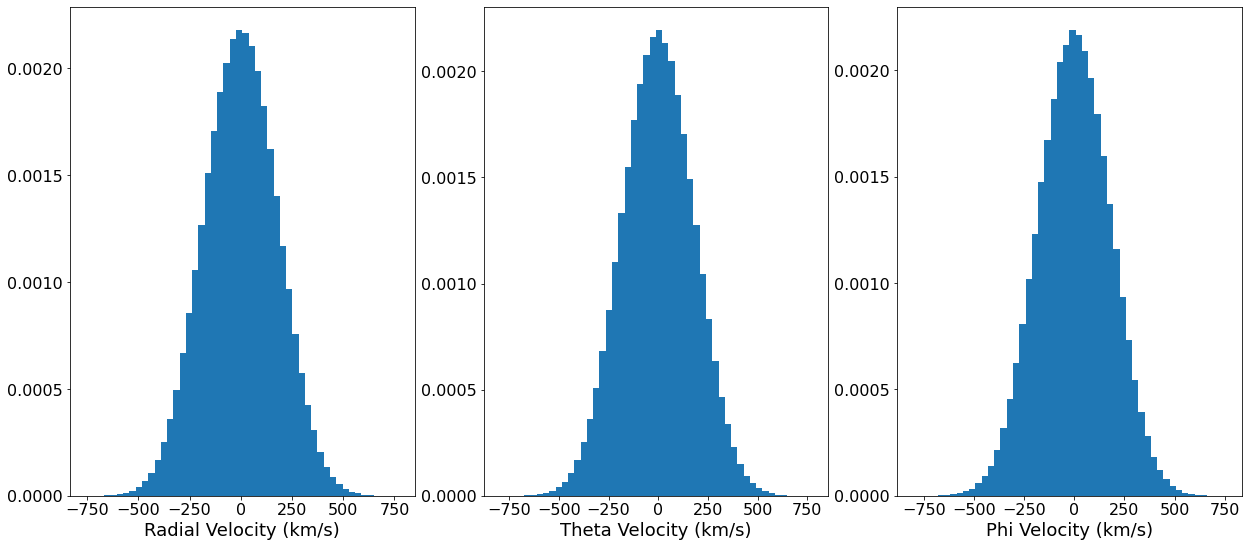

In [12]:
# Converting the velocities to spherical coordinates.
velVec = mwHalo.cartesianPhaseSpacePoints[3:6]
posVec = mwHalo.cartesianPhaseSpacePoints[0:3]

radVel = (mwHalo.cartesianPhaseSpacePoints[3]*mwHalo.cartesianPhaseSpacePoints[0] + mwHalo.cartesianPhaseSpacePoints[4]*mwHalo.cartesianPhaseSpacePoints[1] + mwHalo.cartesianPhaseSpacePoints[5]*mwHalo.cartesianPhaseSpacePoints[2])/mwHalo.radii
thetaUnitVec = np.array((mwHalo.cartesianPhaseSpacePoints[0]*mwHalo.cartesianPhaseSpacePoints[2],mwHalo.cartesianPhaseSpacePoints[1]*mwHalo.cartesianPhaseSpacePoints[2],-mwHalo.cartesianPhaseSpacePoints[0]**2-mwHalo.cartesianPhaseSpacePoints[1]**2)/(mwHalo.radii*np.sqrt(mwHalo.cartesianPhaseSpacePoints[0]**2+mwHalo.cartesianPhaseSpacePoints[1]**2)))
thetaVel = mwHalo.cartesianPhaseSpacePoints[3]*thetaUnitVec[0] + mwHalo.cartesianPhaseSpacePoints[4]*thetaUnitVec[1] + mwHalo.cartesianPhaseSpacePoints[5]*thetaUnitVec[2]
phiUnitVec = np.array((-mwHalo.cartesianPhaseSpacePoints[1]/np.sqrt(mwHalo.cartesianPhaseSpacePoints[0]**2+mwHalo.cartesianPhaseSpacePoints[1]**2),mwHalo.cartesianPhaseSpacePoints[0]/np.sqrt(mwHalo.cartesianPhaseSpacePoints[0]**2+mwHalo.cartesianPhaseSpacePoints[1]**2),0))
phiVel = mwHalo.cartesianPhaseSpacePoints[3]*phiUnitVec[0] + mwHalo.cartesianPhaseSpacePoints[4]*phiUnitVec[1] + mwHalo.cartesianPhaseSpacePoints[5]*phiUnitVec[2]

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,9))
ax1.hist(radVel,50,density=True)
ax1.set_xlabel('Radial Velocity (km/s)')
ax2.hist(thetaVel,50,density=True)
ax2.set_xlabel('Theta Velocity (km/s)')
ax3.hist(phiVel,50,density=True)
ax3.set_xlabel('Phi Velocity (km/s)')

<h1>Phase Space Analysis</h1>

First off, we're going to sample the phase space function defined in the NFWHalo class at a grid of values for radii and speed.

In [13]:
nr=100 # how many radii do we want to sample?
ns=100 # how many speeds do we want to sample?

normRadiusList = np.linspace(.000001,1,nr)
speedList = np.linspace(.000001,np.max(mwHalo.speeds),ns)
radGrid, speedGrid = np.meshgrid(normRadiusList,speedList,sparse=False, indexing='ij')

phaseSpaceGrid = np.zeros((nr,ns))
boxSize = (np.max(mwHalo.speeds)/ns)*(mwHalo.rDelta/nr) # has units of (km/s * pc)

updateInt = int(.1*nr)
for i in range(nr):
    if (i+1)%updateInt == 0:
        print("Calculation is "+str(100*(i+1)/nr)+" % done")
    for j in range(ns):
        phaseSpaceGrid[i,j] = boxSize*mwHalo.rDelta**2*(4*np.pi*radGrid[i,j]*speedGrid[i,j])**2*NFW.phaseSpaceDistribution(radGrid[i,j],speedGrid[i,j],mwHalo.haloAttributes)

phaseSpaceIntApprox = np.sum(phaseSpaceGrid)
print(phaseSpaceIntApprox)

Calculation is 10.0 % done
Calculation is 20.0 % done
Calculation is 30.0 % done
Calculation is 40.0 % done
Calculation is 50.0 % done
Calculation is 60.0 % done
Calculation is 70.0 % done
Calculation is 80.0 % done
Calculation is 90.0 % done
Calculation is 100.0 % done
0.9821410747796658


This tells me that very little of the occupied phase space is being cut off by placing a limit on the speed. This phase space density function seems to integrate to 1 (becomes arbitrarily close to 1) as we sample it more finely.

<h1>Comparing generated vs. theoretical phase space distributions</h1>

Text(0.5, 1.0, 'Generated (w/ theory overlaid as a contour)')

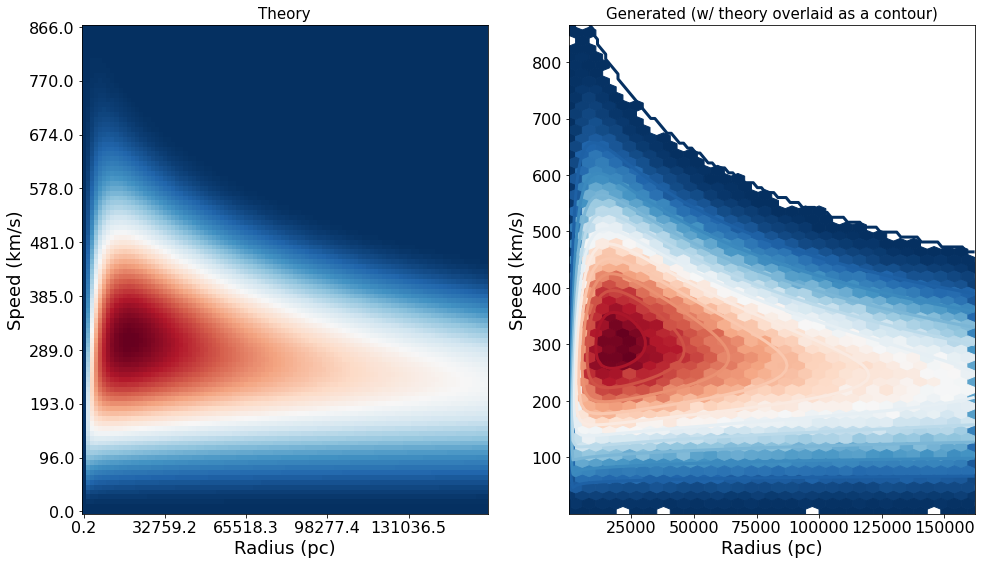

In [15]:
fig,(ax1, ax2)= plt.subplots(1,2,figsize=(16,9))

ax1.imshow(np.transpose(phaseSpaceGrid),origin='lower',aspect='auto',cmap='RdBu_r')
ax1.set_ylabel('Speed (km/s)')
ax1.set_xlabel('Radius (pc)')
num_x_labels = 6
step_r = int(nr/(num_x_labels-1))
ax1.set_xticks(np.arange(0,nr,step_r))
ax1.set_xticklabels(np.round(mwHalo.rDelta*normRadiusList[::step_r],1))
num_y_labels = 10
step_s = int(ns/(num_y_labels-1))
ax1.set_yticks(np.arange(0,ns,step_s))
ax1.set_yticklabels(np.round(speedList[::step_s],0))
ax1.set_title('Theory')

ax2.hexbin(
    mwHalo.radii, 
    mwHalo.speeds,
    mincnt=1,gridsize=(30,30),cmap='RdBu_r'
)
x=mwHalo.rDelta*normRadiusList
y=speedList
ax2.contour(x,y,np.transpose(phaseSpaceGrid),cmap='RdBu_r',linewidths=3, levels=10)
ax2.set_xlabel("Radius (pc)")
ax2.set_ylabel("Speed (km/s)")
ax2.set_title("Generated (w/ theory overlaid as a contour)")

<h1>Checking my inverse transform sampling implementation with a bunch of different distributions</h1>

In [ ]:
import inverseTransform as ITS

CDF = lambda x: x**2
PDF = lambda x: 2*x

testpoints = np.linspace(0,1,1000000)

PDF_eval = np.array(PDF(testpoints))
PDF_gen = []

for i in range(len(testpoints)):
    PDF_gen.append(ITS.inverseTransformSampling(CDF, (0,1)))

In [ ]:
plt.hist(PDF_gen,100,density=True)
plt.plot(testpoints,PDF_eval)

In [ ]:
import inverseTransform as ITS

CDF = lambda x: .8*(1/2)*(1-np.cos(np.pi*x))
PDF = lambda x: .8*np.pi*np.sin(np.pi*x)/2

testpoints = np.linspace(0,1,1000000)

PDF_eval = np.array(PDF(testpoints))
PDF_gen = []

for i in range(len(testpoints)):
    PDF_gen.append(ITS.inverseTransformSampling(CDF, (0,1)))

In [ ]:
plt.hist(PDF_gen,100,density=True)
plt.plot(testpoints,PDF_eval/.8)

In [ ]:
CDF = lambda x: x**5
PDF = lambda x: 5*x**4

testpoints = np.linspace(0,1,100000)

PDF_eval = np.array(PDF(testpoints))
PDF_gen = []

for i in range(len(testpoints)):
    PDF_gen.append(ITS.inverseTransformSampling(CDF, (0,1)))

In [ ]:
plt.hist(PDF_gen,100,density=True)
plt.plot(testpoints,PDF_eval)

In [ ]:
from scipy import special

This curve below looks great. I wanted to see if my sampling was having specific problems with things w/ PDFs that look like gaussian/MB distributions, but it handled it perfectly. Makes me think that there is some stupid thing I am doing when I generate the "exact" distribution for the speeds.

In [ ]:
sigma=.2

PDF = lambda x: (1/(2*np.pi*sigma**2))**(3/2)*4*np.pi*x**2*np.exp(-x**2/(2*sigma**2))
CDF = lambda x: np.sqrt(1/(np.pi*sigma**2))*(-np.sqrt(2)*np.exp(-x**2/(2*sigma**2))*x + np.sqrt(np.pi)*sigma*special.erf(x/(np.sqrt(2)*sigma)))

testpoints = np.linspace(0,1,100000)

PDF_eval = np.array(PDF(testpoints))
PDF_gen = []

for i in range(len(testpoints)):
    PDF_gen.append(ITS.inverseTransformSampling(CDF, (0,1)))

In [ ]:
plt.hist(PDF_gen,200,density=True)
plt.plot(testpoints,PDF_eval)

<h2> Abandoned checks from the MB approach </h2>

In [ ]:
# This cell finds the speed probability distribution function integrated over all radii. It steps through speeds, integrating over the PDF values for
# that speed at each radii before moving on to the next one. This cell is slow!

nTest = 300 # This can stay somewhat low, 100 is okay, don't go much higher.
PDF_over_r = np.zeros(nTest)
speedsList = np.linspace(0.01,np.max(mwHalo.speeds),nTest) # Starting at 0 will probably throw a roundoff error, ignore that...
abserr = np.zeros(nTest)
const = -8*np.pi*mwHalo.rho0*mwHalo.G*mwHalo.rScale**2
for i in range(nTest):
    disp = lambda normRad: NFW.radialVelocityDispersion(normRad,mwHalo.haloAttributes)
    integrad = lambda normRad: mwHalo.rDelta*(4*np.pi*speedsList[i]*normRad*mwHalo.rDelta)**2*NFW.massDensity(normRad,mwHalo.haloAttributes)*np.exp(-speedsList[i]**2/(2*disp(normRad)**2))/(np.sqrt(128*np.pi**5)*mwHalo.rho0*mwHalo.rScale**3*disp(normRad)**3*NFW.gFcn(mwHalo.c))
    rminNorm = ((const/(speedsList[i]**2))*np.real(
        special.lambertw(
            np.exp(speedsList[i]**2/const)*(speedsList[i]**2/const) , -1
        )
    ) - 1)*(mwHalo.rScale/mwHalo.rDelta)
    #print(rminNorm)
    if rminNorm>1:
        rminNorm=1
    result, err = integrate.quad(integrad,0,rminNorm)
    abserr[i]=err
    PDF_over_r[i]=result

In [ ]:
# Plotting the speed PDF integrated over all radii.
fig, ax1 = plt.subplots(figsize=(10,10))
color = 'tab:blue'
ax1.set_xlabel('Speed (km/s)')
ax1.set_ylabel('Speed PDF')
n, bins,_ = ax1.hist(mwHalo.speeds,nTest, color=color,density=True,label="Generated Distribution",align='mid')

color = 'tab:red'
ax1.plot(speedsList[:], PDF_over_r[:], color=color,linewidth=2,label="Numerically Integrated Distribution")
ax1.legend()
ax1.set_xlim(0,np.max(speedsList))

#plt.yscale('log')
plt.show()
print(np.sum(PDF_over_r-n)*np.max(speedsList)/nTest)
print(np.sum(PDF_over_r)*np.max(speedsList)/nTest)

Check dispersion numerical integration: (It does a good job)

In [ ]:
from mpmath import *

nTest = 100 # This can stay somewhat low, 100 is okay, don't go much higher.
radiiList = np.linspace(.000001,1,nTest) # Starting at 0 will probably throw a roundoff error, ignore that...
dispApprox = []
dispExact = []
c = mwHalo.c
for i in range(nTest):
    dispApprox.append(NFW.radialVelocityDispersion(radiiList[i],mwHalo.haloAttributes))
    prefactor = np.sqrt(mwHalo.virialSpeed**2*(c**2*radiiList[i]*(1+c*radiiList[i])**2)/(NFW.gFcn(c)))
    dispExact.append(
        prefactor*np.sqrt((6*(c*radiiList[i]+1)**2*(c*radiiList[i])**2*float(polylog(2,-c*radiiList[i]))
         +np.pi**2*(c*radiiList[i])**4
         +3*(c*radiiList[i])**4*np.log((c*radiiList[i])+1)**2
         +(c*radiiList[i])**4*np.log((c*radiiList[i])+1)
         +2*np.pi**2*(c*radiiList[i])**3
         -7*(c*radiiList[i])**3
         +6*(c*radiiList[i])**3*np.log((c*radiiList[i])+1)**2
         -4*(c*radiiList[i])**3*np.log((c*radiiList[i])+1)
         +np.pi**2*(c*radiiList[i])**2
         -9*(c*radiiList[i])**2
         +3*(c*radiiList[i])**2*np.log((c*radiiList[i])+1)**2
         -((c*radiiList[i])+1)**2*(c*radiiList[i])**2*np.log((c*radiiList[i]))
         -8*(c*radiiList[i])**2*np.log((c*radiiList[i])+1)
         -(c*radiiList[i])
         -2*(c*radiiList[i])*np.log((c*radiiList[i])+1)
         +np.log((c*radiiList[i])+1))/(2*(c*radiiList[i])**2*((c*radiiList[i])+1)**2)
                    ))
    
plt.plot(radiiList,dispApprox,linewidth=4)
plt.plot(radiiList,dispExact)
plt.xlabel('Radius Normalized to Cutoff R_Delta')
plt.ylabel('Radial Velocity Dispersion (km/s)')

print(np.sum(np.array(dispApprox)-np.array(dispExact))) # Okay it does a REALLY good job of getting the dispersion by numerical integration.

<h2> Scratch </h2>

I'm interested in how much the cutoff of velocities at the kinematic limit and the virial speed chops off occupied phase space. I can test this very easily by sampling this phase space function over the phase space we utilize (which is normalized by integrating over ALL 6D phase space) and seeing how much this discrete integration differs from 1.

In [ ]:
approxList = np.array((0.8156089020449218,0.9117045254879874,0.9569139256211714,0.9786084206934264,0.9892139747051578,0.9944552935872416,0.9970605665449931,0.9983593530340494,0.9990077835695818))
resolutionList = np.array((10**2,20**2,40**2,80**2,160**2,320**2,640**2,1280**2,2560**2))

plt.scatter(np.log10(resolutionList),np.log10(1-approxList))
plt.xlabel('log10 number of pixels')
plt.ylabel('1 - phase space integral')
# I think what this is telling me is that while there are of course diminishing returns here, this plot could probably maintain
# a relatively straight line for a few more data points before that slight curve starts to bottom this thing out. I don't know
# where it will bottom out at, but I think I would need far more computational power to reach the resolution required to completely
# eliminate sampling error.

# The purpose of this exercise was to see if sampling error would be subdominate to the error we subject ourselves to by cutting off the speed
# instead of taking it to infinity, which is what our function is technically normalized by. This tells me that the dominant error
# is just sampling error and that we do not need to worry about cutoff error. Good!